In [18]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import pandas as pd

Load a real file for visual inspection.

In [2]:
test_path = "onderive_data_2/12Hz/layer368.csv"
test = pd.read_csv(test_path,header=0,index_col=0)

In [3]:
def expand_df(df):
    r = df.loc[:,("X","Y")].values
    # Orientation
    v = r[2:,:] - r[:-2,:]
    v = np.r_[[r[1,:]-r[0,:]],v,[r[-1,:]-r[-2,:]]]
    theta = np.arctan2(v[:,0],v[:,1])
    # Acceleration
    v_mid = r[1:,:] - r[:-1,:]
    a = v_mid[1:,:] - v_mid[:-1,:]
    a = np.r_[[v_mid[0,:]],a,[v_mid[-1,:]]]
    accel = np.einsum('ki,kj->k',a,v) / np.linalg.norm(v)
    # Add columns
    df["Orientation"] = theta
    df["Speed"] = np.linalg.norm(v,axis=1)
    df["Acceleration"] = accel
    return df

In [4]:
test = expand_df(test)

In [5]:
test.describe()

/root/miniconda3/envs/dev/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,P,X,Y,Photodiode,Spot Centroid X,Spot Centroid Y,Spot area (um2),Spot major axis (um),Spot minor axis (um),Spot orientation,...,Layer,Spatter number,Spatter total area,Spatter mean area,Spatter median area,Spatter mean mean intensity,Spatter median mean intensity,Orientation,Speed,Acceleration
count,287296.000000,287296.000000,287296.000000,287296.000000,254904.000000,254904.000000,254904.000000,2.540100e+05,254009.000000,254010.000000,...,287296.0,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000,287296.000000,287296.000000,2.872960e+05
mean,167.666808,-526.981367,590.406343,296590.359121,61.433014,68.678012,15459.223782,inf,130.216547,46.989157,...,8.0,1.182037,20.384599,17.203979,17.133638,27.002994,26.987512,-0.182938,62.323122,2.408747e-08
std,69.249870,52670.531350,53327.635889,4260.319097,2.675993,2.515649,5545.626353,NaN,24.226818,30.956123,...,0.0,0.484691,19.648133,13.996556,13.981826,3.446359,3.445608,2.039812,64.249250,2.138869e-02
min,-7.468680,-76344.214727,-77247.914961,283462.000000,55.000000,62.000000,5285.500000,9.803061e+01,54.872860,0.000000,...,8.0,1.000000,5.500000,5.500000,5.500000,21.846154,21.846154,-3.141381,0.158788,-6.516779e-01
25%,123.808739,-43440.586372,-25917.850098,294384.000000,59.000000,67.000000,11532.000000,1.600864e+02,111.740026,31.503418,...,8.0,1.000000,9.000000,8.500000,8.500000,24.636364,24.631579,-2.564510,35.047583,-6.798155e-03
50%,183.375061,-17775.143696,18279.475571,296798.000000,61.000000,69.000000,15376.000000,1.827356e+02,134.214137,43.147961,...,8.0,1.000000,14.500000,13.000000,13.000000,26.350000,26.333333,0.070343,62.111965,1.049452e-06
75%,231.646805,25752.029031,37260.979272,299071.000000,63.000000,70.000000,19220.000000,2.049182e+02,147.860583,53.210846,...,8.0,1.000000,25.000000,20.500000,20.500000,28.345467,28.313323,0.977954,69.910324,6.823840e-03
max,389.685913,76328.271758,77366.741875,392007.000000,68.000000,76.000000,100424.500000,inf,820.273216,180.000000,...,8.0,7.000000,748.000000,170.500000,170.500000,51.933333,51.933333,3.141593,545.666033,4.344864e-01


(68000.0, 78000.0)

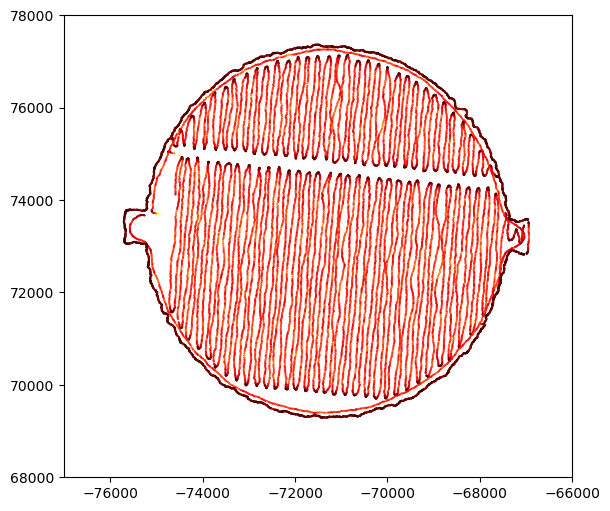

In [6]:
fig,ax = plt.subplots(figsize=(10,6))

ax.scatter(test[test.loc[:,"P"]>0.0].loc[:,"X"].values,test[test.loc[:,"P"]>0.0].loc[:,"Y"].values,
           c=test[test.loc[:,"P"]>0.0].loc[:,"Speed"].values,
           s=0.3,
           cmap="hot")
ax.set_aspect("equal")
ax.set_xlim([-77000,-66000])
ax.set_ylim([68000,78000])
#ax.set_xlim([-76000,-74000])
#ax.set_ylim([72000,74000])

Separate out this path data

In [7]:
data_locs = (test.loc[:,"P"].values>0.0) & (test.loc[:,"X"].values > -77000) & (test.loc[:,"X"].values < -66000) & (test.loc[:,"Y"].values > 68000) & (test.loc[:,"Y"].values < 78000)
x = test[data_locs].loc[:,"X"].values
y = test[data_locs].loc[:,"Y"].values

In [150]:
def adjust_and_pad(x,y,pad=1.0):
    x_min = x.min() ; x_max = x.max()
    y_min = y.min() ; y_max = y.max()
    x_mid = 0.5*(x_min+x_max)
    y_mid = 0.5*(y_min+y_max)
    r_max = np.sqrt((x-x_mid)**2 + (y-y_mid)**2).max()
    if pad > 0.0:
        out = np.zeros(int(np.ceil(((2*pad+1)*x.shape[0]))),dtype=np.cdouble)
        start = int(np.ceil(pad*x.shape[0]))
        end = int(np.ceil(pad*x.shape[0]))+x.shape[0]
        out[start:end] = ((x-x_mid)+(y-y_mid)*1j) / r_max
    else:
        out = ((x - x_mid) + (y - y_mid)*1j)/r_max
    return out

def unpad(z,pad):
    if pad > 0.0:
        old_shape = int(np.floor(z.shape[0]/(2*pad+1)))
        start = int(np.ceil(pad*old_shape))
        end = int(np.ceil(pad*old_shape))+old_shape
        return z[start:end]
    else:
        return z
        

In [126]:
z = adjust_and_pad(x[13818:],y[13818:])
R = fft(z)
omega = fftfreq(R.shape[0],1.0)

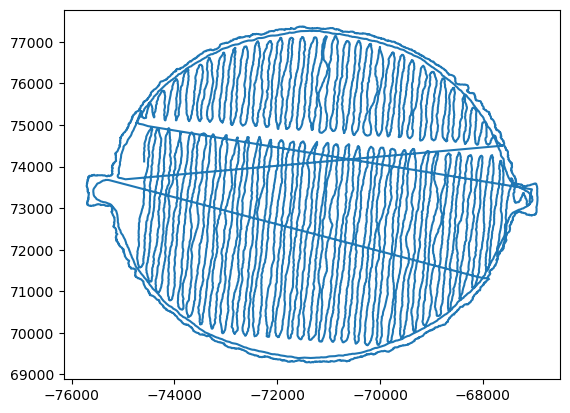

In [127]:
plt.plot(x,y)

In [128]:
freq_cutoff = 2.0 * 2*np.pi/(z.shape[0]/3)

(-10.0, 10.0)

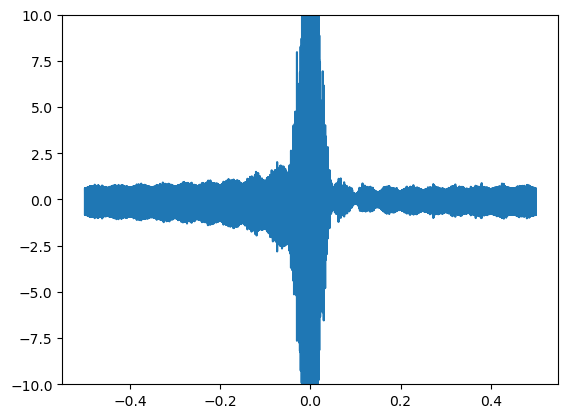

In [129]:
plt.plot(omega,np.real(R))
plt.ylim(-10,10)

In [130]:
cutoff = int(np.ceil(freq_cutoff * z.shape[0]))
R_masked = np.zeros_like(R)
R_masked[:cutoff] = R[:cutoff]
R_masked[-cutoff:] = R[-cutoff:]
z_tr = ifft(R_masked)

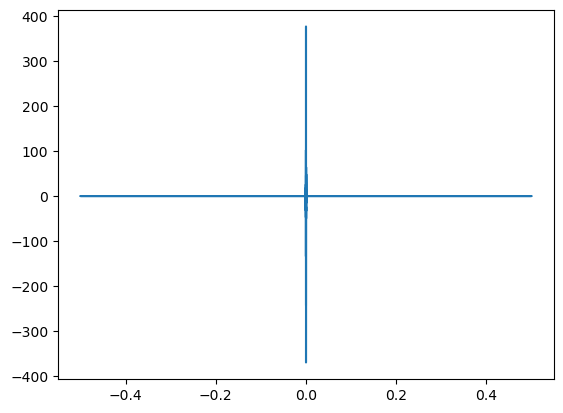

In [131]:
plt.plot(omega,np.real(R_masked))

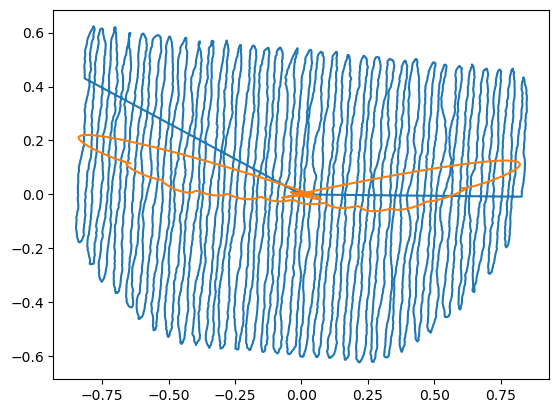

In [137]:
plt.plot(np.real(z),np.imag(z))
plt.plot(np.real(z_tr),np.imag(z_tr))


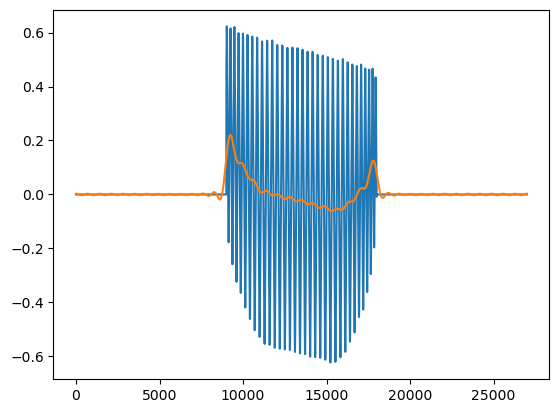

In [139]:
plt.plot(np.imag(z))
plt.plot(np.imag(z_tr))


### Filtering code
Pass this code a block of x,y and return a filtered-FFT reconstruction score. 

In [156]:
def fft_recon_score(x,y,**kwargs):
    pad = kwargs.get("pad",1.0)
    f_c_factor = kwargs.get("f_c_factor",2.0)
    # Pad x,y 
    z = adjust_and_pad(x,y,pad)
    R = fft(z)
    freq_cutoff = f_c_factor * 2*np.pi/(z.shape[0]/(1+2*pad))
    ind_cutoff = int(np.ceil(freq_cutoff * z.shape[0]))
    # Mask R based on cutoff
    R_masked = np.zeros_like(R)
    R_masked[:ind_cutoff] = R[:ind_cutoff]
    R_masked[-ind_cutoff:] = R[-ind_cutoff:]
    z_tr = ifft(R_masked)
    # Score 
    score = 1.0 - np.abs(unpad(z,pad) - unpad(z_tr,pad)).mean()
    return score

In [158]:
fft_recon_score(x[13818:],y[13818:])

0.9710945678690565

Break up dataset on a condition

In [236]:
import matplotlib as mpl

In [247]:
cmap = mpl.colormaps["coolwarm_r"]

In [248]:
score_thresh = 0.9

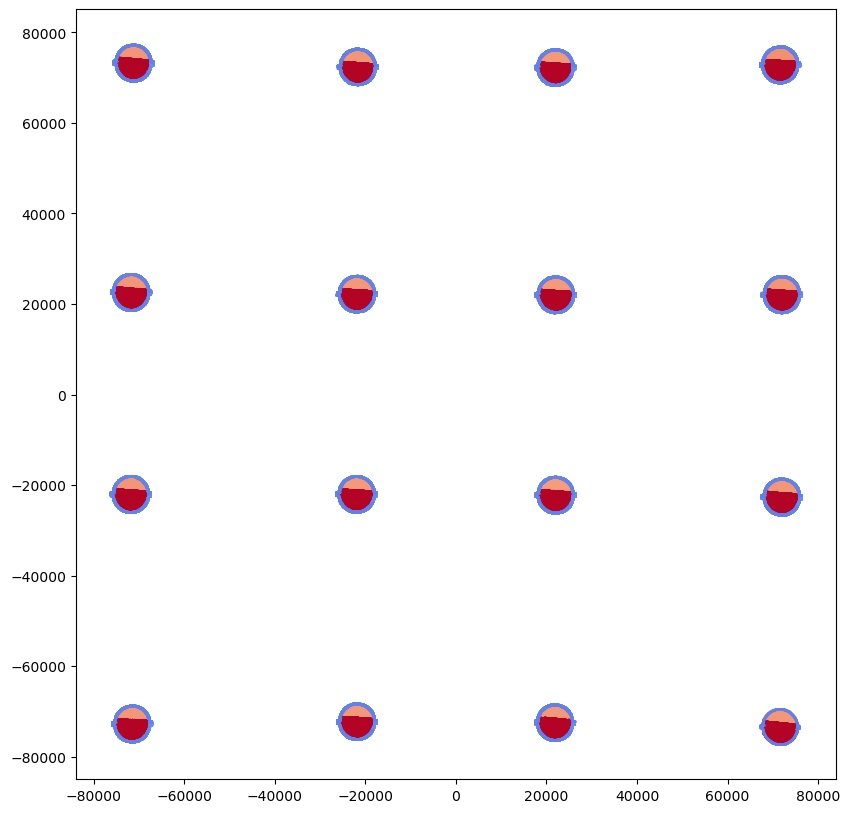

In [251]:
fig,ax = plt.subplots(figsize=(10,10))

on = test.loc[:,"P"].values > 0.0
ends   = np.argwhere(on[:-2] * (~on)[1:-1] * (~on)[2:]).ravel()
starts = np.argwhere(on[2:]  * (~on)[1:-1]  * (~on)[:-2]).ravel() + 2
if on[0]:
    starts = np.r_[[0],starts]
if on[-1]:
    ends = np.r_[ends,[on.shape[0]]]

scores = []
for start,end in zip(starts,ends):
    x,y = test.loc[start:end,("X","Y")].values.T
    # Process and plot
    score = fft_recon_score(x,y)
    scores.append(score)

    ax.scatter(x,y,
            color=cmap((score - score_thresh)/(2*(1-score_thresh))+0.5),
            s=0.3)
    ax.set_aspect("equal")
    